- 참고
- https://debuggercafe.com/transfer-learning-with-pytorch/

### 사전학습 모델 VGG11
- 모델 정의 없이 import 해서 사용

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
 
from torchvision import models

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
	
transform = transforms.Compose([transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


- 사전학습 모델 정의

In [4]:
# from torchvision import models

vgg11 = models.vgg11(pretrained=True)
vgg11.to(device)

print(vgg11)

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


## 출력 수 설정
- 현재 설정된 out_features=1000을 클래스가 10개 이므로 feature 10개로 변경
- vgg11.classifier[6]은 위에 프린트된 모델을 잘 살펴보았을 때 맨 마지막 (6): Linear에 해당됨

## 사전학습 모델 사용시 주의 점
- 반드시 로드한 가중치는 변경되지 않도록 freezing해야 함
- VGG11 모델 중 FC이전까지 파라미터 고정시키면 됨

In [5]:
# change the number of classes 
vgg11.classifier[6].out_features = 10
 
# freeze convolution weights
for param in vgg11.features.parameters():
    param.requires_grad = False

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.classifier.parameters(), lr=0.001, momentum=0.9)


- validate, train 모델함수 정의




In [11]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0

    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [9]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0

    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        
        loss.backward()
        optimizer.step()
    
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
 
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

- validate와 train 모델함수를 이용한 모델학습

In [10]:
# 위에서 설계한 함수를 통해 모델학습하고,
# loss와 accuracy(validate와 train간의 정확도) 찍어보기

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = train(vgg11, trainloader)    #위에서 만든 train모델함수에 넣고 돌리기
    val_epoch_loss, val_epoch_accuracy = validate(vgg11, testloader)      #위에서 만든 vlidate모델함수
   
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    print(train_accuracy, val_accuracy)
    
end = time.time()
 
print((end-start)/60, 'minutes')

Train Loss: 0.0261, Train Acc: 72.78
[72.776] [83.32]
Train Loss: 0.0150, Train Acc: 83.20
[72.776, 83.202] [83.32, 84.42]
Train Loss: 0.0116, Train Acc: 87.01
[72.776, 83.202, 87.006] [83.32, 84.42, 85.76]
Train Loss: 0.0091, Train Acc: 89.75
[72.776, 83.202, 87.006, 89.746] [83.32, 84.42, 85.76, 86.39]
Train Loss: 0.0070, Train Acc: 92.30
[72.776, 83.202, 87.006, 89.746, 92.3] [83.32, 84.42, 85.76, 86.39, 87.16]
Train Loss: 0.0052, Train Acc: 94.23
[72.776, 83.202, 87.006, 89.746, 92.3, 94.232] [83.32, 84.42, 85.76, 86.39, 87.16, 87.21]
Train Loss: 0.0039, Train Acc: 95.85
[72.776, 83.202, 87.006, 89.746, 92.3, 94.232, 95.854] [83.32, 84.42, 85.76, 86.39, 87.16, 87.21, 87.36]
Train Loss: 0.0027, Train Acc: 97.15
[72.776, 83.202, 87.006, 89.746, 92.3, 94.232, 95.854, 97.152] [83.32, 84.42, 85.76, 86.39, 87.16, 87.21, 87.36, 87.38]
Train Loss: 0.0020, Train Acc: 97.94
[72.776, 83.202, 87.006, 89.746, 92.3, 94.232, 95.854, 97.152, 97.944] [83.32, 84.42, 85.76, 86.39, 87.16, 87.21, 87.36

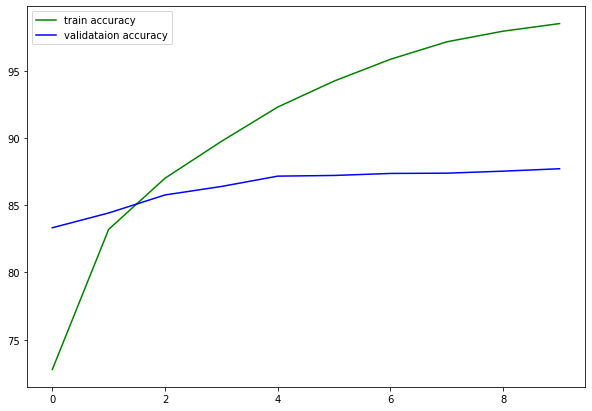

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

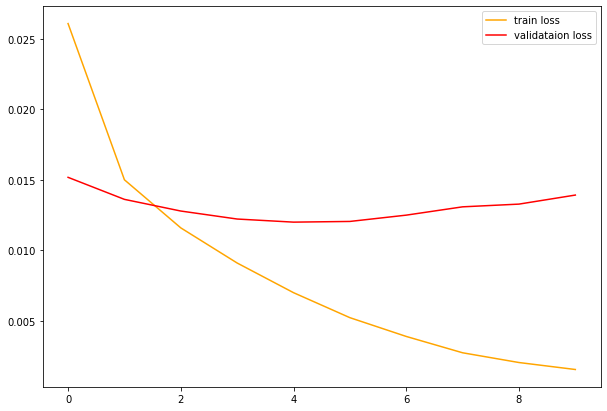

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

